In [71]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

# Define Operators

Here we define the Poisson operator, the residual calculation (without building the matrix), relaxation, the restriction operation, and interpolation.

In [63]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

def poissonop(n):
    """
    Poisson operator h^{-2} * [-1 2 1]
    """
    A = (n+1)**2 * sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(n,n), format='csr')
    return A

def residual(u, f):
    """
    f - A u
    """
    n = len(f)
    r = np.zeros(len(u))
    r[1:-1] = f[1:-1] - ((n+1)**2) * (2 * u[1:-1] - u[2:] - u[:-2])
    r[0]    = f[0]    - ((n+1)**2) * (2 * u[0]    - u[1])
    r[-1]   = f[-1]   - ((n+1)**2) * (2 * u[-1]   - u[-2])
    return r

def relax(u, f, nu):
    """
    Weighted Jacobi
    """
    n = len(u)
    Dinv = 1.0 / (2.0 * ((n+1)**2))
    omega = 2.0 / 3.0
    unew = u.copy()
    
    for steps in range(nu):
        unew = unew + omega * Dinv * residual(unew, f)
    
    return unew

def interpolate(uc):
    """interpolate u of size 2**(k-1)-1 to 2**(k)-1"""
    uf = np.zeros((2*len(uc) + 1,))
    uf[:-1:2] = 0.5 * uc
    uf[1::2] = uc
    uf[2::2] += 0.5 * uc
    return uf

def restrict(uf):
    """restrict u of size 2**(k)-1 to 2**(k-1)-1"""
    uc = 0.25 * uf[:-1:2] + 0.5 * uf[1::2] + 0.25 * uf[2::2]
    return uc

# Define Cycles

Here we define a number of different cycles.  A V-cycle down to $2^{kmin}-1$ (vcycle) and a two level cycle (vcycle2).

In [77]:
def vcycle(kmax, kmin, u, f, nu):
    ulist = [None for k in range(kmax+1)]
    flist = [None for k in range(kmax+1)]

    print('grid: ', end=' ')
    # down cycle
    for k in range(kmax, kmin, -1):
        print(k, end=' ')
        u = relax(u, f, nu)
        ulist[k] = u
        flist[k] = f
        
        f = restrict(residual(u, f))
        u = np.zeros(f.shape)
        ulist[k-1] = u
        flist[k-1] = f

    # coarsest grid
    print(kmin, end=' ')
    Ac = poissonop(2**kmin - 1)
    flist[kmin] = f
    ulist[kmin] = sla.spsolve(Ac, f)

    # up cycle
    for k in range(kmin+1, kmax+1, 1):
        print(k, end=' ')
        u = ulist[k]
        f = flist[k]
        uc = ulist[k-1]
        u += interpolate(uc)
        u = relax(u, f, nu)
    print('.')
    return u

def vcycle3(u, f, nu):
    f0 = f.copy()
    u0 = u.copy()
    
    u0 = relax(u0, f0, nu)
    f1 = restrict(residual(u0, f0))
    
    u1 = relax(np.zeros(len(f1)), f1, nu)
    f2 = restrict(residual(u1, f1))
    
    A2 = poissonop(len(f2))
    u2 = sla.spsolve(A2, f2)
    
    u1 += interpolate(u2)
    u1 = relax(u1, f1, 1)
    
    u0 += interpolate(u1)
    u0 = relax(u0, f0, 1)
    return u0

def vcycle2(u0, f0, nu):
    u0 = relax(u0, f0, nu)
    f1 = restrict(residual(u0, f0))
    u1 = sla.spsolve(poissonop(len(f1)), f1)    
    ui = interpolate(u1)
    u0 = u0 + ui
    u0 = relax(u0, f0, nu)
    return u0

In [98]:
kmax = 7
kmin = 2

# set up fine problem
n = 2**kmax - 1

xx = np.linspace(0, 1, n+2)[1:-1]

f = 2 - 12 * xx**2

ustar = xx**4 - xx**2
A = poissonop(len(f))
udstar = sla.spsolve(A, f)
print(hnorm(ustar - udstar))
u = np.random.rand(len(f))

# set up smoothing sweeps
nu = 2

res = []
err = []

res.append(hnorm(residual(u, f)))
for i in range(12):
    u = vcycle(kmax, kmin, u, f, nu)
    #u = vcycle3(u, f, nu)
    res.append(hnorm(residual(u, f)))
    err.append(hnorm(u - ustar))
print(res)

9.84950596997e-07
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
grid:  7 6 5 4 3 2 3 4 5 6 7 .
[960.92331228182775, 14.060317037893531, 1.718429526034849, 0.2878574538675715, 0.051602477660101134, 0.0096244336254378629, 0.0018272633004643804, 0.00034882193866237794, 6.6517416427923544e-05, 1.2618917672456247e-05, 2.3754684477127443e-06, 4.43133598532541e-07, 8.1884895194158902e-08]


# Plot the solution and approximate solution

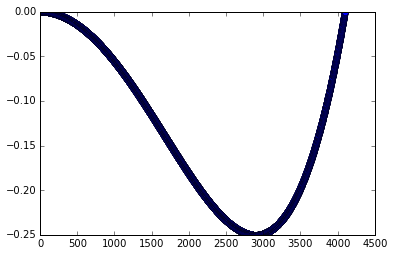

In [94]:
plt.plot(u, 'g-', lw=3)
plt.plot(ustar, 'bo', lw=3)

# Output the residual convergence factors

In [100]:
res = np.array(res)
print(res[1:] / res[:-1])

[ 0.01463209  0.12221841  0.16751193  0.179264    0.18651108  0.18985671
  0.19089856  0.19069161  0.18970848  0.18824661  0.18654577  0.18478602]


# Output the residual and error

In [101]:
for r, e in zip(res, err):
    print('residual: %5.5e   error: %5.5e' % (r, e))

residual: 9.60923e+02   error: 5.00817e-03
residual: 1.40603e+01   error: 7.48589e-04
residual: 1.71843e+00   error: 1.33400e-04
residual: 2.87857e-01   error: 2.45121e-05
residual: 5.16025e-02   error: 4.65917e-06
residual: 9.62443e-03   error: 1.31668e-06
residual: 1.82726e-03   error: 1.00290e-06
residual: 3.48822e-04   error: 9.86396e-07
residual: 6.65174e-05   error: 9.85139e-07
residual: 1.26189e-05   error: 9.84981e-07
residual: 2.37547e-06   error: 9.84956e-07
residual: 4.43134e-07   error: 9.84951e-07
